In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import *
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)

import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
data = pd.read_csv('Employee-Attrition.csv')
data['Attrition'] = np.where(data['Attrition'] == 'Yes', 1, 0)

print(data.shape[0], 'employees and', data.shape[1], features)

(1470, 35)

In [4]:
print('Numeric features:')
print(data.select_dtypes(include=[np.number]).columns)

print()

print('Categorical features:')
print(data.select_dtypes(include=['O']).columns)

Index(['Age', 'Attrition', 'DailyRate', 'DistanceFromHome', 'Education',
       'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction',
       'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

(array([0, 1]), <a list of 2 Text xticklabel objects>)

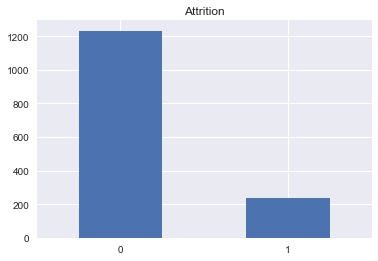

In [6]:
data.Attrition.value_counts().plot.bar()
plt.title('Attrition')
plt.xticks(rotation=0)

In [7]:
# Dummify the categorical variables

for i in data.select_dtypes(include=['O']).columns:
    dums = pd.get_dummies(data[i])
    dums.rename(columns=lambda x: str(i) + '_' + x, inplace=True)
    del data[i]
    data = pd.concat([data, dums], axis=1)

Let's see what correlates with attrition.

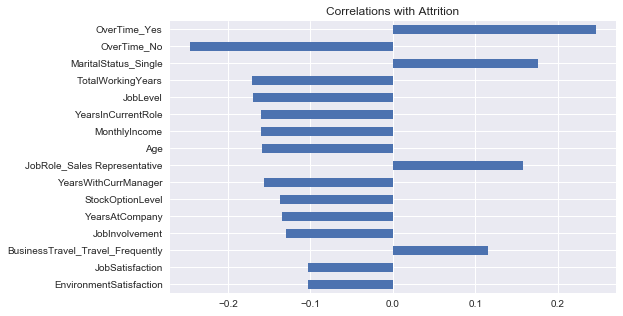

In [9]:
def absolute_correlations(col, df=data, asc=False):
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    corrs = corrs[corrs.absol < .99]
    return corrs.sort_values('absol', ascending=asc).drop('absol', axis=1)

att = absolute_correlations('Attrition', df=data, asc=True)

att[np.abs(att.correlation) > .1].plot(kind='barh', legend=False,
                                       figsize=(8,5),
                                       title='Correlations with Attrition')

I think we already have a useful insight.

Overtime is the best predictor of whether someone leaves. We might later find that other factors are equally (or even *more*) useful, but this squares with my intuition. Burnout appears to be a huge problem.

Single employees are more likely to leave, but I'm not sure why.

Salespeople (and likely the traveling ones) are also at increased risk. Again, this appears to be a burnout issue.

(array([0, 1]), <a list of 2 Text xticklabel objects>)

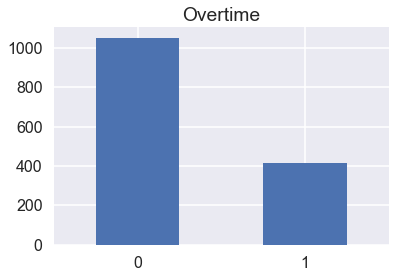

In [208]:
# How many people are working overtime?

data.OverTime_Yes.value_counts().plot.bar()
plt.title('Overtime')
plt.xticks(rotation=0)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

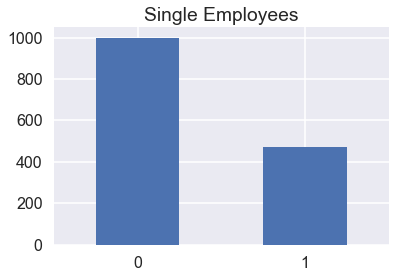

In [209]:
# How many people are single?

data.MaritalStatus_Single.value_counts().plot.bar()
plt.title('Single Employees')
plt.xticks(rotation=0)

Know what might be fun and interesting to try? Company Singles Parties. :)
    
It would be pretty funny (and cost-effective) if this actually reduced turnover!

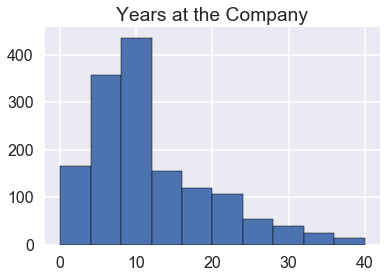

In [212]:
# Years at the company

data.TotalWorkingYears.hist(edgecolor='black')

plt.title('Years at the Company')

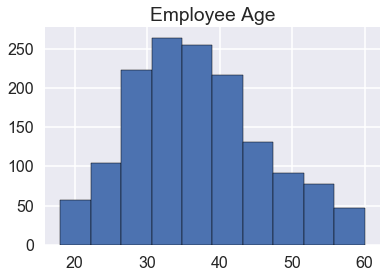

In [214]:
data.Age.hist(edgecolor='black')

plt.title('Employee Age')

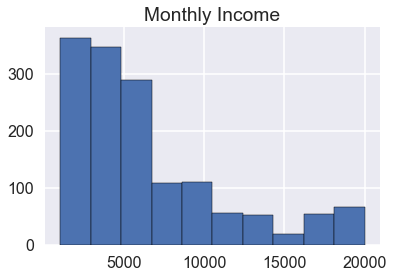

In [216]:
data.MonthlyIncome.hist(edgecolor='black')

plt.title('Monthly Income')

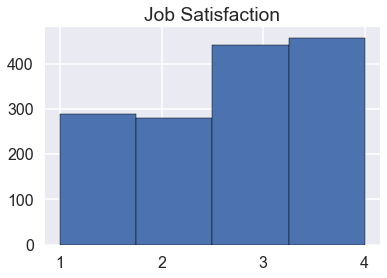

In [219]:
data.JobSatisfaction.hist(edgecolor='black', bins=4)

plt.title('Job Satisfaction')

Are we rewarding loyalty?

In [222]:
np.corrcoef(data.YearsAtCompany, data.MonthlyIncome)[0,1]

0.51428482573319656

Very well, in fact. We're seeing lots of evidence that it isn't our most senior people who are leaving.

# Machine Learning

Let's create a machine learning model to predict attrition. I'll do it in two ways:

1. Optimize for accuracy. I'll try different algorithms and techniques, and not worry about interpretability.

2. Optimize for understanding. I'll build a simple decision tree managers can then refer to when making decisions.

I'll use ROC-AUC as my metric because it works well for imbalanced classes. Classifiers typically predict a "1" when the pred_proba is above 0.50, but the ROC curve lets you see the tradeoff between sensitivity and specificity for all possible thresholds, rather than just the one that was chosen by the modeling technique.

In [202]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

y = data['Attrition']
x = data.drop('Attrition', axis=1)

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=.2)

In [23]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy='constant', constant=0)

cv = cross_val_score(clf, x, y, cv=kf, scoring='roc_auc')

# Naive AUC score is always 0.5
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

Mean score: 0.5
Std Dev:    0.0


In [175]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
params = {'penalty': ['l1', 'l2'],
         'C': [.1, .5, .75, 1, 1.25, 1.5]}
grid = GridSearchCV(clf, param_grid=params, cv=kf, scoring='roc_auc').fit(xtrain, ytrain)
lr = grid.best_estimator_

cv = cross_val_score(lr, xtrain, ytrain, cv=kf, scoring='roc_auc')

print(lr, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

LogisticRegression(C=1.25, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

Mean score: 0.825429757562
Std Dev:    0.0349876078911


In [176]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

cv = cross_val_score(nb, xtrain, ytrain, cv=kf, scoring='roc_auc')

print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

Mean score: 0.772174148822
Std Dev:    0.0442230263552


In [179]:
from xgboost import XGBClassifier

clf = XGBClassifier(n_jobs=-1)
params = {'max_depth': [2,3,4],
         'n_estimators': [50, 75, 100, 125],
         'learning_rate': [.1]}
grid = GridSearchCV(clf, param_grid=params, cv=3, scoring='roc_auc').fit(x.values, y)
xg = grid.best_estimator_

cv = cross_val_score(xg, x.values, y, cv=kf, scoring='roc_auc')

print(clf, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1) 

Mean score: 0.805794382431
Std Dev:    0.0247564977478


In [186]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_jobs=-1)
params = {'max_depth': np.arange(5,13,1),
         'n_estimators': [10],
          'min_samples_leaf': [3,4,5,6,8],
          'min_samples_split': [4,5,6,10,12,15]
         }
grid = GridSearchCV(clf, param_grid=params, cv=3, scoring='roc_auc').fit(x.values, y)
rf = grid.best_estimator_

cv = cross_val_score(rf, x.values, y, cv=kf, scoring='roc_auc')

print(rf, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=15,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 

Mean score: 0.772209008893
Std Dev:    0.0468598825031


In [68]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()
params = {'max_depth': [2],#np.arange(2,14,2),
         'n_estimators': [450],
         'min_samples_leaf': np.arange(4,7,1),#[1,2,3,4,5,6,10],
         'min_samples_split': np.arange(4,7,1),#[2,3,4,5,6,10]
         'loss': ['deviance']
         }
grid = GridSearchCV(clf, param_grid=params, cv=3, scoring='roc_auc').fit(x.values, y)
gb = grid.best_estimator_

cv = cross_val_score(gb, x.values, y, cv=kf, scoring='roc_auc')

print(gb, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=5, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=450,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False) 

Mean score: 0.819729781982
Std Dev:    0.0277971410284


In [69]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier()
params = {'max_depth': np.arange(11,13,1),
         'n_estimators': [50,75,100],
         'min_samples_leaf': np.arange(1,11,1),#[1,2,3,4,5,6,10],
         'min_samples_split': np.arange(2,11,1),#[2,3,4,5,6,10]
         }
grid = GridSearchCV(clf, param_grid=params, cv=kf, scoring='roc_auc').fit(x.values, y)
et = grid.best_estimator_

cv = cross_val_score(et, x.values, y, cv=kf, scoring='roc_auc')

print(et, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=12, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=6,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False) 

Mean score: 0.799426710405
Std Dev:    0.0360902219957


In [70]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
params = {'n_neighbors': np.arange(23,33,2),
          'p': np.arange(12,17,1),
          'leaf_size': np.arange(1,5,1)
         }
grid = GridSearchCV(clf, param_grid=params, cv=kf, scoring='roc_auc').fit(x.values, y)
knn = grid.best_estimator_

cv = cross_val_score(knn, x.values, y, cv=kf, scoring='roc_auc')

print(knn, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=31, p=13,
           weights='uniform') 

Mean score: 0.620175856732
Std Dev:    0.0556973259642


In [187]:
lr = LogisticRegression(C=1.25, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

xg = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=15,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

gb = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=5, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=450,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

et = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=12, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=6,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

knn = KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=31, p=13,
           weights='uniform')

Now to finalize the model using a stacked classifier. We can use a grid search to determine which classifiers work best together -- it's pretty cool.

In [82]:
from mlxtend.classifier import StackingClassifier
from itertools import combinations
regs = [lr, nb, xg, rf, gb, et, knn]
reg_combinations =\
[list(i) for i in combinations(regs, 3)]

stack = StackingClassifier(classifiers=[nb], meta_classifier=lr, use_probas=True, average_probas=True)
params = {'classifiers': reg_combinations,
    'meta_classifier': regs}

grid = GridSearchCV(stack, param_grid=params, cv=3, scoring='roc_auc').fit(xtrain.values, ytrain)
stack = grid.best_estimator_

cv = cross_val_score(stack, xtrain, ytrain, cv=kf, scoring='roc_auc')

print(stack, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

StackingClassifier(average_probas=True,
          classifiers=[LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), GradientBoostingClassif...stimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)],
          meta_classifier=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          use_features_in_secondary=False, use_probas=True, verbose=0) 

Mean score: 0.826574561222
Std Dev:    0.0396162184217


Let's view the ROC curve next. I use a couple custom functions for this; one to save the predictor's results to a dataframe, and another to plot the dataframe I've created.

In [102]:
def results_df(label_test, pred_proba):
    '''
    Compares how well the model is identifying people compared
    to random chance.
    '''
    results = pd.DataFrame()

    results['actual'] = label_test
    results['predicted'] = pred_proba
    
    results.sort_values('predicted', ascending=False, inplace=True)
    
    # Counting positive observations
    results['model_count'] = pd.Series.cumsum(results.actual)
    results['percentage'] = 1/len(results)
    results['random_count'] = pd.Series.cumsum(results['percentage']) * np.sum(results['actual'])
    
    # Percentage of the total found
    results['model_select'] = results['model_count']/np.sum(results['actual'])
    results['random_select'] = pd.Series.cumsum(results.percentage)

    del results['percentage']
    
    return results

res = results_df(ytest, stack.predict_proba(xtest)[:,1])

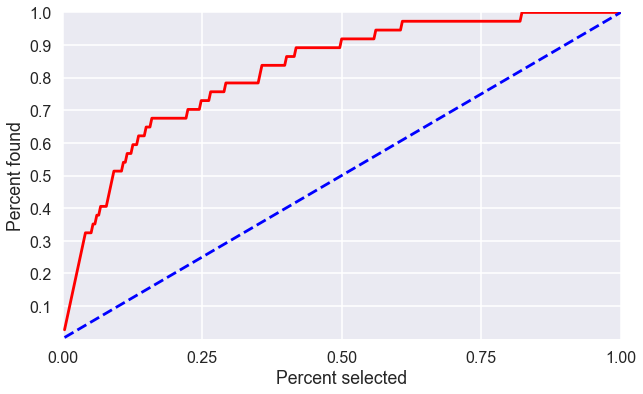

In [106]:
def plot_curve(df):
    plt.plot(df.random_select, df.model_select, color='red')
    plt.plot(df.random_select, df.random_select, color='blue', linestyle='--')

    plt.ylabel('Percent found')
    plt.xlabel('Percent selected')

    plt.ylim(0,1)
    plt.xlim(0,1)

    plt.xticks([0, .25, .5, .75, 1])
    plt.yticks([.1, .2, .3, .4,
                .5, .6, .7, .8, .9, 1])

    from pylab import rcParams
    rcParams['figure.figsize'] = 10, 6
    
plot_curve(res)

You can see that we identify 70% of the leavers within the first 25% of people our model ranks. It reaches nearly 90% of leavers after it has ranked the top 50%. I would consider this very good performance, indeed! 

# Clustering our former employees

First, let's determine the ideal number of clusters.

In [241]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Cluster those who left
left = data[data.Attrition == 1]

# Test different numbers of clusters
for i in range(2,11):
    cl = KMeans(n_clusters=i, random_state=42).fit(left.drop('Attrition', axis=1))
    print(i, silhouette_score(left.drop('Attrition', axis=1), cl.labels_))

2 0.500842068733
3 0.390919131267
4 0.394596685441
5 0.423937852181
6 0.402940626305
7 0.426994378651
8 0.417738824866
9 0.413060794127
10 0.4180392647


(array([0, 1]), <a list of 2 Text xticklabel objects>)

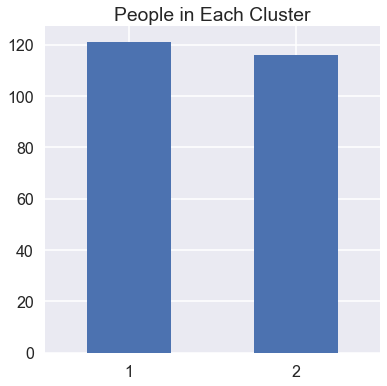

In [249]:
cl = KMeans(n_clusters=2, random_state=42).fit(left.drop('Attrition', axis=1))
left['Cluster'] = cl.labels_ + 1

left.Cluster.value_counts().plot.bar()
plt.title('People in Each Cluster')
rcParams['figure.figsize'] = 3, 3
plt.xticks(rotation=0)

Perfect -- they're about evenly distributed. Let's look at the characteristics of each cluster.

In [264]:
differences = left.groupby('Cluster').mean().T
differences['Stayed'] = data[data.Attrition == 0].mean()
differences.drop('Attrition', inplace=True)

# Calculate the percentage difference vs. those who stay
differences['Difference_Cluster_1'] = (differences[1] - differences['Stayed'])/differences['Stayed']
differences['Difference_Cluster_2'] = (differences[2] - differences['Stayed'])/differences['Stayed']

# Absolute value, for sorting
differences['Difference_Cluster_1_abs'] = np.abs(differences['Difference_Cluster_1'])
differences['Difference_Cluster_2_abs'] = np.abs(differences['Difference_Cluster_2'])

differences.head()

Cluster,1,2,Stayed,Difference_Cluster_1,Difference_Cluster_2,Difference_Cluster_1_abs,Difference_Cluster_2_abs
Age,34.247934,32.939655,37.561233,-0.088211,-0.123041,0.088211,0.123041
DailyRate,780.611570,718.810345,812.504461,-0.039253,-0.115315,0.039253,0.115315
DistanceFromHome,10.851240,10.405172,8.915653,0.217100,0.167068,0.217100,0.167068
Education,2.818182,2.862069,2.927007,-0.037180,-0.022186,0.037180,0.022186
EmployeeCount,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000


In [269]:
cl1 = differences.sort_values('Difference_Cluster_1_abs', ascending=False)[[1, 'Stayed', 'Difference_Cluster_1']]

cl1.head(10)

Cluster,1,Stayed,Difference_Cluster_1
JobRole_Sales Representative,0.132231,0.040552,2.260826
OverTime_Yes,0.528926,0.234388,1.256627
EducationField_Human Resources,0.033058,0.016221,1.038017
JobRole_Research Director,0.000000,0.063260,-1.000000
MaritalStatus_Single,0.520661,0.283861,0.834215
JobRole_Manager,0.016529,0.078670,-0.789895
JobRole_Human Resources,0.057851,0.032441,0.783264
BusinessTravel_Travel_Frequently,0.297521,0.168694,0.763668
JobRole_Laboratory Technician,0.280992,0.159773,0.758694
EducationField_Technical Degree,0.140496,0.081103,0.732314


It appears that a big characteristic of cluster 1 is HR. People in HR are about twice as likely to leave.

In [270]:
cl2 = differences.sort_values('Difference_Cluster_2_abs', ascending=False)[[2, 'Stayed', 'Difference_Cluster_2']]

cl2.head(10)

Cluster,2,Stayed,Difference_Cluster_2
JobRole_Sales Representative,0.146552,0.040552,2.613966
OverTime_Yes,0.543103,0.234388,1.317116
JobRole_Healthcare Representative,0.017241,0.098946,-0.825749
MaritalStatus_Single,0.491379,0.283861,0.731059
JobRole_Research Director,0.017241,0.063260,-0.727454
EducationField_Marketing,0.172414,0.100568,0.714405
BusinessTravel_Travel_Frequently,0.284483,0.168694,0.686381
JobRole_Manager,0.025862,0.078670,-0.671258
BusinessTravel_Non-Travel,0.043103,0.111922,-0.614880
JobRole_Manufacturing Director,0.043103,0.109489,-0.606322


Meanwhile, cluster 2 is characterized by travel, marketing, and sales. Lets see why people leave in both of these departments/clusters.

In [19]:
hr = data[(data['EducationField_Human Resources'] == 1) | (data['JobRole_Human Resources'] == 1)]
sales = data[(data['JobRole_Healthcare Representative'] == 1) | (data['EducationField_Marketing'] == 1) |\
            (data['JobRole_Sales Representative'] == 1) | (data['JobRole_Sales Executive'] == 1)]

print(hr.shape[0], 'people in HR and', sales.shape[0], 'in sales.')

58 people in HR and 554 in sales.


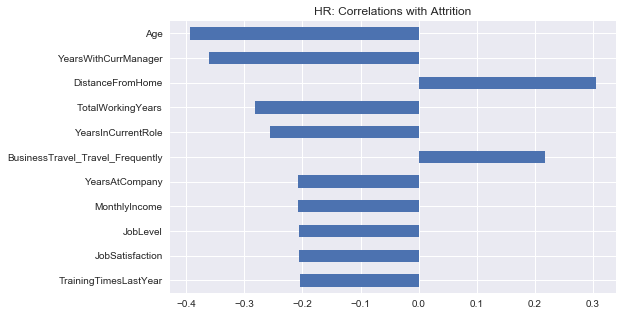

In [12]:
att_hr = absolute_correlations('Attrition', df=hr, asc=True).T

# Remove job role and dept
att_hr = att_hr[[i for i in att_hr.columns if "JobRole" not in i and "Department" not in i]].T

att_hr[np.abs(att_hr.correlation) > .2].plot(kind='barh', legend=False,
                                       figsize=(8,5),
                                       title='HR: Correlations with Attrition')

HR folks don't like commuting or traveling. But if they settle in with the company, they tend to stick around.

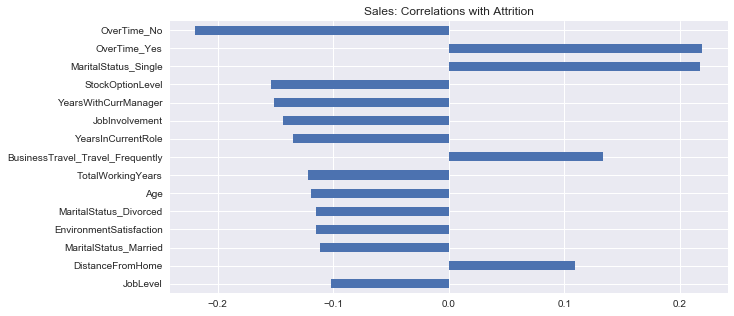

In [13]:
att_sales = absolute_correlations('Attrition', df=sales, asc=True).T

# Remove job role and dept
att_sales = att_sales[[i for i in att_sales.columns if "JobRole" not in i and "Department" not in i]].T

att_sales[np.abs(att_sales.correlation) > .1].plot(kind='barh', legend=False,
                                       figsize=(10,5),
                                       title='Sales: Correlations with Attrition')

People in sales don't like overtime or traveling. It's interesting how *single* salespeople are more likely to leave. I would've expected the married folks to miss their families. This is why we analyze our data!

# Manager Recommendations

The model above is great for identifying employees at risk of leaving. But we should still pass along some guidelines to managers so they can reduce attrition risk on a day-to-day basis.

To do this, I think a decision tree is the most appropriate technique.

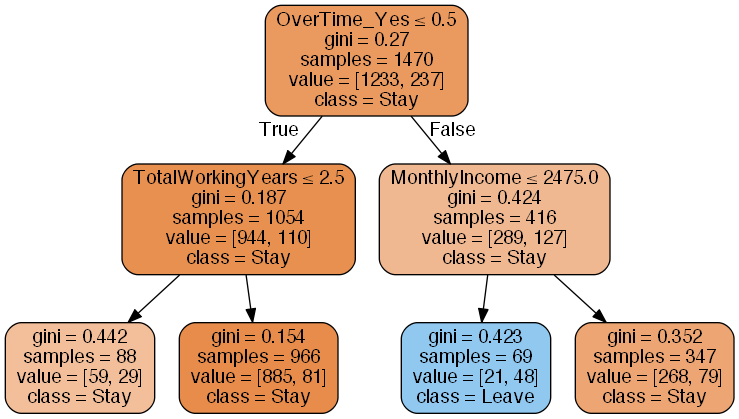

In [204]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image  
import pydotplus

# I also tried a max_depth of 3, but 2 works just about as well here
tree = DecisionTreeClassifier(max_depth=2).fit(x,y)

dot_data = export_graphviz(tree, out_file=None, 
                         feature_names=x.columns,  
                         class_names=['Stay', 'Leave'],  
                         filled=True, rounded=True,  
                         special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

This actually gives us a very simple rule of thumb: if an employee is working overtime and making less than $2475/month, they have nearly a 70% chance of leaving.

The other valuable insight is that it's the new employees that are turning over at an increased rate. We might be able to address this by changing the our selection procedures, and finding people who are a better fit for the company. Or create a better onboarding process so new hires feel integrated into their teams and valued at the workplace.